# Using BERT on the SQuAD v1 Dataset

In [1]:
pip install transformers datasets torch tqdm scikit-learn nltk evaluate tqdm matplotlib

Note: you may need to restart the kernel to use updated packages.


### Load Dataset

In [2]:
import splitData

train_ds, val_ds, test_ds = splitData.load_and_split_data()

One data sample:
{
  "id": "56bfe7eaa10cfb1400551389",
  "title": "Beyoncé",
  "context": "After Hurricane Katrina in 2005, Beyoncé and Rowland founded the Survivor Foundation to provide transitional housing for victims in the Houston area, to which Beyoncé contributed an initial $250,000. The foundation has since expanded to work with other charities in the city, and also provided relief following Hurricane Ike three years later.",
  "question": "How much did Beyonce initially contribute to the foundation?",
  "answers": {
    "text": [
      "$250,000"
    ],
    "answer_start": [
      190
    ]
  }
}


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\Arya Rahmanian/nltk_data'
    - 'C:\\anaconda\\nltk_data'
    - 'C:\\anaconda\\share\\nltk_data'
    - 'C:\\anaconda\\lib\\nltk_data'
    - 'C:\\Users\\Arya Rahmanian\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


## Load BERT

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    get_linear_schedule_with_warmup,
    default_data_collator,
    BertConfig
)
import evaluate
from tqdm.auto import tqdm
from torch.optim import AdamW
import time
import numpy as np
from postprocessQA import postprocess_qa_predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
model_name = "distilbert/distilbert-base-uncased"
config = BertConfig.from_pretrained(
    model_name,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
model.to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

c:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Arya Rahmanian\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all confi

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

In [4]:
batch_size = 8
eval_batch= 16
epochs = 10
learning_rate = 3e-5

### Pre-Process Data

In [5]:
max_len = 512    
doc_stride = 128    
pad_on_right = tokenizer.padding_side == "right"

In [6]:
def train_preprocess_fn(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_len,
        truncation="only_second" if pad_on_right else "only_first",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = tokenized.pop("overflow_to_sample_mapping")
    offset_map = tokenized.pop("offset_mapping")

    starts, ends = [], []
    for i, offsets in enumerate(offset_map):
        seq_ids = tokenized.sequence_ids(i)
        example_i  = sample_map[i]
        answer = examples["answers"][example_i]

        if not answer["answer_start"]:
            starts.append(0); ends.append(0)
            continue

        start_char= answer["answer_start"][0]
        end_char = start_char +len(answer["text"][0])
        ctx_idxs = [idx for idx, sid in enumerate(seq_ids) if sid == (1 if pad_on_right else 0)]
        first_ctx, last_ctx = ctx_idxs[0], ctx_idxs[-1]

        if not (offsets[first_ctx][0] <= start_char and offsets[last_ctx][1] >= end_char):
            starts.append(0); ends.append(0)
            continue

        valid_starts = [idx for idx in ctx_idxs if offsets[idx][0] <= start_char]
        valid_ends = [idx for idx in ctx_idxs if offsets[idx][1] >= end_char]
        starts.append(max(valid_starts) if valid_starts else first_ctx)
        ends.append(min(valid_ends) if valid_ends else last_ctx)

    tokenized["start_positions"] = starts
    tokenized["end_positions"]   = ends
    return tokenized

In [5]:
train_features = train_ds.map(train_preprocess_fn,batched=True,remove_columns=train_ds.column_names)
train_loader = DataLoader(train_features, batch_size=batch_size,shuffle=True, collate_fn=default_data_collator)

NameError: name 'train_ds' is not defined

In [7]:
def eval_preprocess_fn(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_len,
        truncation="only_second" if pad_on_right else "only_first",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = tokenized["overflow_to_sample_mapping"]
    tokenized["example_id"] = [examples["id"][i] for i in sample_map]
    return tokenized

In [8]:
val_features = val_ds.map(eval_preprocess_fn, batched=True,remove_columns=val_ds.column_names)
test_features = test_ds.map(eval_preprocess_fn, batched=True, remove_columns=test_ds.column_names)

val_loader = DataLoader(val_features, batch_size=eval_batch,shuffle=False,collate_fn=default_data_collator)
test_loader = DataLoader(test_features,batch_size=eval_batch,shuffle=False,collate_fn=default_data_collator)

NameError: name 'val_ds' is not defined

In [ ]:
val_labelled = val_ds.map(
    train_preprocess_fn,
    batched=True,
    remove_columns=val_ds.column_names
)
val_labelled_loader = DataLoader(
    val_labelled,batch_size=eval_batch, shuffle=False,
    collate_fn=default_data_collator
)

## HyperParams

In [11]:
total_steps = len(train_loader) * epochs
optim = AdamW(
    model.parameters(),
    lr=1e-5,                
    weight_decay=0.01       
)
sched = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
gradient_accumulation_steps = 2 

In [14]:
history = {
    "train_loss": [], 
    "val_loss": [],
    "val_em": [],
    "val_f1": []
}
best_val_loss = float("inf")
patience = 2
stale = 0
metric_squad = evaluate.load("squad") 

In [15]:
total_time = 0.0
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    
    # ─── TRAIN 
    
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(tqdm(train_loader, desc=f"[{epoch}] train")):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optim.step(); sched.step(); optim.zero_grad()

        total_train_loss += loss.item() * gradient_accumulation_steps

    avg_train = total_train_loss / len(train_loader)
    history["train_loss"].append(avg_train)
    
    # ─── VALIDATION 
    model.eval()
    metric_squad     = evaluate.load("squad")
    val_losses       = []
    all_start_logits = []
    all_end_logits   = []

    for loss_batch, feat_batch in tqdm(zip(val_labelled_loader, val_loader),
                                       total=len(val_loader),
                                       desc=f"[{epoch}] eval"):
        loss_inputs = {k: v.to(device) for k, v in loss_batch.items()}
        with torch.no_grad():
            out = model(**loss_inputs)
        val_losses.append(out.loss.item())


        all_start_logits.append(out.start_logits.cpu().numpy())
        all_end_logits.append(out.end_logits.cpu().numpy())

    avg_val = sum(val_losses) / len(val_losses)
    history["val_loss"].append(avg_val)

    flat_start = np.concatenate(all_start_logits, axis=0)
    flat_end   = np.concatenate(all_end_logits,   axis=0)
    
    final_preds = postprocess_qa_predictions(
        examples=val_ds,         
        features=val_features,   
        predictions=(flat_start, flat_end),
        version_2_with_negative=False,
        n_best_size=20,
        max_answer_length=30,
    )

    # ─── COMPUTE EM/F1 
    metric_squad.add_batch(
        predictions=[{"id": eid, "prediction_text": text}
                     for eid, text in final_preds.items()],
        references=[{"id": ex["id"], "answers": ex["answers"]}
                    for ex in val_ds]
    )
    res_val = metric_squad.compute()
    history["val_em"].append(res_val["exact_match"])
    history["val_f1"].append(res_val["f1"])

    # ─── EARLY STOP / SAVE BEST 
    if avg_val < best_val_loss:
        best_val_loss = avg_val; stale = 0
        model.save_pretrained("best-distilBERT-squad")
        tokenizer.save_pretrained("best-distilBERT-squad")
    else:
        stale += 1
        if stale >= patience:
            print(f"Stopping early at epoch {epoch} (no improvement in {patience} epochs).")
            break

    epoch_time = time.time() - epoch_start
    total_time += epoch_time
    print(
        f"Epoch {epoch:2d} • "
        f"train_loss={avg_train:.4f} • "
        f"val_loss={avg_val:.4f} "
        f"(EM={res_val['exact_match']:.2f}, F1={res_val['f1']:.2f}) • "
        f"time={epoch_time:.1f}s"
    )

print(f"\nTotal training time: {total_time:.1f}s")

[1] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[1] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  1 • train_loss=3.2781 • val_loss=1.5531 (EM=51.50, F1=66.40) • time=554.5s


[2] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[2] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  2 • train_loss=1.4380 • val_loss=1.1867 (EM=60.67, F1=75.24) • time=554.9s


[3] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[3] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  3 • train_loss=1.1121 • val_loss=1.1071 (EM=63.37, F1=77.55) • time=555.8s


[4] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[4] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  4 • train_loss=0.9054 • val_loss=1.0729 (EM=64.12, F1=78.09) • time=553.9s


[5] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[5] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  5 • train_loss=0.7501 • val_loss=1.1354 (EM=65.08, F1=78.51) • time=554.1s


[6] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[6] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Stopping early at epoch 6 (no improvement in 2 epochs).

Total training time: 2773.1s


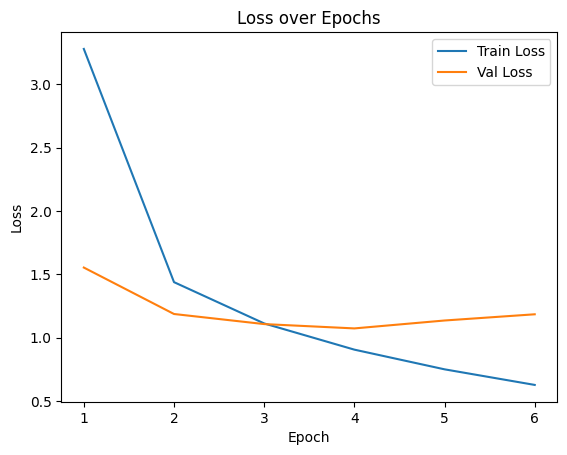

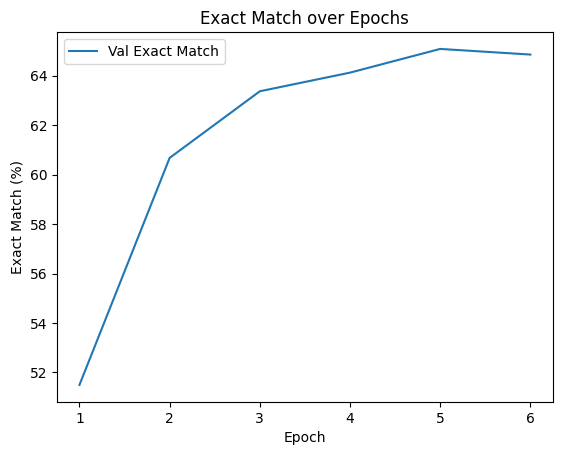

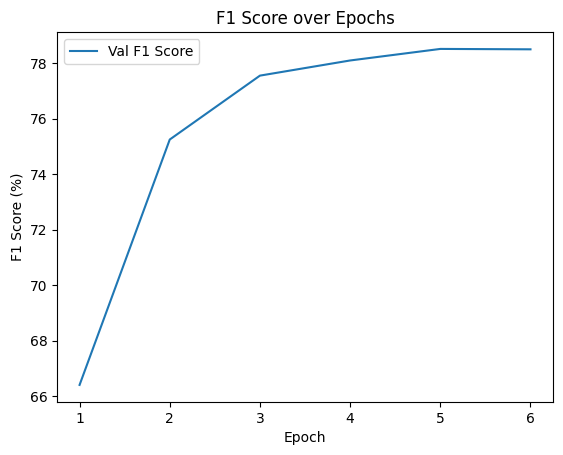

In [16]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

plt.figure()
plt.plot(epochs_range, history["val_em"], label="Val Exact Match")
plt.xlabel("Epoch")
plt.ylabel("Exact Match (%)")
plt.title("Exact Match over Epochs")
plt.legend()
plt.savefig("em_plot.png")
plt.show()

plt.figure()
plt.plot(epochs_range, history["val_f1"], label="Val F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (%)")
plt.title("F1 Score over Epochs")
plt.legend()
plt.savefig("f1_plot.png")
plt.show()

## Test

### Load Saved Model

In [17]:
model = AutoModelForQuestionAnswering.from_pretrained("best-distilBERT-squad").to(device)
tokenizer = AutoTokenizer.from_pretrained("best-distilBERT-squad")

In [18]:
import random

### Visualize some Q/A

In [19]:
model.eval()

n_show = 5
indices = random.sample(range(len(test_ds)), n_show)

for idx in indices:
    example = test_ds[idx]
    question = example["question"]
    context = example["context"]
    answers = example["answers"]["text"]  #ground-truth answers

    # tokenize
    inputs = tokenizer(
        question,
        context,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        return_offsets_mapping=True,
    ).to(device)

    with torch.no_grad():
        outs = model(**{k: v for k, v in inputs.items() if k in ("input_ids","attention_mask","token_type_ids")})

    start_logits = outs.start_logits[0].cpu()
    end_logits= outs.end_logits[0].cpu()
    offset_map = inputs["offset_mapping"][0].cpu()

    start_idx = torch.argmax(start_logits)
    end_idx= torch.argmax(end_logits)

    char_start = offset_map[start_idx][0].item()
    char_end = offset_map[end_idx][1].item()

    pred_answer = context[char_start:char_end]

    print(f"\nExample #{idx}")
    print(f"Q: {question}")
    print(f"\n{context[:200].replace(chr(10),' ')}")  
    print(f"\nPredicted:\n {pred_answer}")
    print(f"Ground-truth:\n {answers}\n")


Example #6330
Q: Which descendant of Genghis Khan sacked Baghdad?

The invasions of Baghdad, Samarkand, Urgench, Kiev, Vladimir among others caused mass murders, such as when portions of southern Khuzestan were completely destroyed. His descendant Hulagu Khan destroy

Predicted:
 Hulagu Khan
Ground-truth:
 ['Hulagu Khan', 'Hulagu Khan', 'Hulagu Khan']


Example #1752
Q: What is the expression used to identify any given series of problems capable of being solved within time on a deterministic Turing machine?

For a precise definition of what it means to solve a problem using a given amount of time and space, a computational model such as the deterministic Turing machine is used. The time required by a dete

Predicted:
 DTIME(f(n))
Ground-truth:
 ['DTIME(f(n))', 'DTIME(f(n)).', 'DTIME(f(n))']


Example #2865
Q: What was the number of customers that the BBC  reported had yet to receive the service due to failed deliveries?

BSkyB launched its HDTV service, Sky+ HD, on 22 May 2006. Prior 

### Custom Q/A over the Magna Carta

In [20]:
model.eval()

questions = ["What is the importance of the Magna Carta?", "When was the magna carta written?", 
             "Who wrote the magna carta?", "Who was the ruler of England when the magna carta was written?",
            "Who tried to supress the magna carta?", "Who was inspired by the Magna Carta?"
            ]
context  = "Magna Carta Libertatum (Medieval Latin for Great Charter of Freedoms), commonly called Magna Carta or sometimes Magna Charta (Great Charter),[a] is a royal charter[4][5] of rights agreed to by King John of England at Runnymede, near Windsor, on 15 June 1215.[b] First drafted by the Archbishop of Canterbury, Cardinal Stephen Langton, to make peace between the unpopular king and a group of rebel barons who demanded that the King confirm the Charter of Liberties, it promised the protection of church rights, protection for the barons from illegal imprisonment, access to swift and impartial justice, and limitations on feudal payments to the Crown, to be implemented through a council of 25 barons. Neither side stood by their commitments, and the charter was annulled by Pope Innocent III, leading to the First Barons War. After Johns death, the regency government of his young son, Henry III, reissued the document in 1216, stripped of some of its more radical content, in an unsuccessful bid to build political support for their cause. At the end of the war in 1217, it formed part of the peace treaty agreed at Lambeth, where the document acquired the name Magna Carta, to distinguish it from the smaller Charter of the Forest, which was issued at the same time. Short of funds, Henry reissued the charter again in 1225 in exchange for a grant of new taxes. His son, Edward I, repeated the exercise in 1297, this time confirming it as part of Englands statute law. However, Magna Carta was not unique; other legal documents of its time, both in England and beyond, made broadly similar statements of rights and limitations on the powers of the Crown. The charter became part of English political life and was typically renewed by each monarch in turn, although as time went by and the fledgling Parliament of England passed new laws, it lost some of its practical significance. At the end of the 16th century, there was an upsurge in interest in Magna Carta. Lawyers and historians at the time believed that there was an ancient English constitution, going back to the days of the Anglo-Saxons, that protected individual English freedoms. They argued that the Norman invasion of 1066 had overthrown these rights and that Magna Carta had been a popular attempt to restore them, making the charter an essential foundation for the contemporary powers of Parliament and legal principles such as habeas corpus.  It influenced the early American colonists in the Thirteen Colonies and the formation of the United States Constitution, which became the supreme law of the land in the new republic of the United States. Research by Victorian historians showed that the original 1215 charter had concerned the medieval relationship between the monarch and the barons, and not ordinary subjects. Despite the changes in views of historians, the charter has remained a powerful, iconic document, even after almost all of its content was repealed from the statute books in the 19th and 20th centuries. Magna Carta still forms an important symbol of liberty today, often cited by politicians and campaigners, and is held in great respect by the British and American legal communities, Lord Denning describing it in 1956 as the greatest constitutional document of all times—the foundation of the freedom of the individual against the arbitrary authority of the despot. In the 21st century, four exemplifications of the original 1215 charter remain in existence, two at the British Library, one at Lincoln Castle and one at Salisbury Cathedral. There are also a handful of the subsequent charters in public and private ownership, including copies of the 1297 charter in both the United States and Australia. The 800th anniversary of Magna Carta in 2015 included extensive celebrations and discussions, and the four original 1215 charters were displayed together at the British Library. None of the original 1215 Magna Carta is currently in force since it has been repealed; however, four clauses of the original charter are enshrined in the 1297 reissued Magna Carta and do still remain in force in England and Wales.[c]"

for question in questions:
    # tokenize
    inputs = tokenizer(
        question,
        context,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        return_offsets_mapping=True,
    ).to(device)
    
    with torch.no_grad():
        outs = model(**{k: v for k, v in inputs.items() if k in ("input_ids","attention_mask","token_type_ids")})
    
    start_logits = outs.start_logits[0].cpu()
    end_logits   = outs.end_logits[0].cpu()
    offset_map   = inputs["offset_mapping"][0].cpu()
    
    start_idx = torch.argmax(start_logits)
    end_idx   = torch.argmax(end_logits)
    
    char_start = offset_map[start_idx][0].item()
    char_end   = offset_map[end_idx][1].item()
    
    pred_answer = context[char_start:char_end]
    
    print(f"Q: {question}")
    #print(f"Context: \n {context[:200].replace(chr(10),' ')}...")  
    print(f"Predicted: \n {pred_answer}")

Q: What is the importance of the Magna Carta?
Predicted: 
 a royal charter
Q: When was the magna carta written?
Predicted: 
 15 June 1215
Q: Who wrote the magna carta?
Predicted: 
 Cardinal Stephen Langton
Q: Who was the ruler of England when the magna carta was written?
Predicted: 
 King John of England
Q: Who tried to supress the magna carta?
Predicted: 
 King John of England
Q: Who was inspired by the Magna Carta?
Predicted: 
 


In [21]:
from transformers import PreTrainedTokenizerFast

def eval_preprocess_fn(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_len,
        truncation="only_second",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = tokenized.pop("overflow_to_sample_mapping")
    offset_map = tokenized.pop("offset_mapping")
    tokenized["example_id"]  = []
    tokenized["offset_mapping"] = []

    for i, sample_idx in enumerate(sample_map):
        tokenized["example_id"].append(examples["id"][sample_idx])
        seq_ids = tokenized.sequence_ids(i)
        offsets = [
            off if seq_ids[k] == 1 else None
            for k, off in enumerate(offset_map[i])
        ]
        tokenized["offset_mapping"].append(offsets)
    return tokenized

In [22]:
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
import evaluate

qa = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

metric = evaluate.load("squad")  

predictions, references = [], []
for ex in test_ds:
    out = qa(question=ex["question"], context=ex["context"])
    predictions.append({"id": ex["id"], "prediction_text": out["answer"]})
    references.append({"id": ex["id"], "answers": ex["answers"]})

results = metric.compute(predictions=predictions, references=references)
print(f"Exact Match: {results['exact_match']:.2f}%")
print(f"F1 : {results['f1']:.2f}%")

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Exact Match: 75.73%
F1 : 84.40%
